# User Engagement Dataset
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period, identify which factors predict future user adoption.
- A user who is an 'adopted user' with the value of 1
- A user who is not an 'adopted user' with the value of 0

## Imports

In [1]:
import json
from datetime import datetime
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 

## Data wrangling and EDA

In [2]:
# Open file
file_path = '/Users/pandabear/springboard/Takehomeassignment_2/'
takehome_users_df = pd.read_csv(file_path + 'takehome_users.csv', encoding='latin1')
takehome_user_engagement_df = pd.read_csv(file_path + 'takehome_user_engagement.csv', encoding='latin1')

In [3]:
takehome_users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
takehome_users_df.shape

(12000, 10)

In [5]:
takehome_user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
takehome_users_df.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [7]:
takehome_users_df.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [8]:
takehome_users_df.shape

(12000, 10)

In [9]:
# fill na for invited_by_user_id with 0
takehome_users_df.fillna(value=0, inplace=True)

In [10]:
takehome_users_df.isna().sum()

object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

In [11]:
# Convert dates into datetime format
takehome_users_df['creation_time'] = takehome_users_df['creation_time'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))
takehome_users_df['last_session_creation_time'] = takehome_users_df['last_session_creation_time'].apply(lambda x: datetime.fromtimestamp(x))

# Convert float to int
takehome_users_df['invited_by_user_id'] = takehome_users_df['invited_by_user_id'].astype(int)


In [12]:
# If there are rows with no last session time (this means they have not logged in yet) then replace it with the creation_time
takehome_users_df['last_session_creation_time'].fillna(value=takehome_users_df['creation_time'], inplace=True)



In [13]:
takehome_users_df.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                     int64
dtype: object

In [14]:
takehome_user_engagement_df.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [15]:
# Convert object into datetime format
takehome_user_engagement_df['time_stamp'] = takehome_user_engagement_df['time_stamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))


In [16]:
# Count the total number of logins for each user_id
total_logins = takehome_user_engagement_df.user_id.value_counts().reset_index()
total_logins.columns = [['user_id','freq']]
total_logins

,user_id,freq
0,3623,606
1,906,600
2,1811,593
3,7590,590
4,8068,585
...,...,...
8818,4699,1
8819,4698,1
8820,4697,1
8821,4696,1


In [17]:
# How often do logins of 1 occur?
total_logins['freq'].value_counts()

(freq,)
1          6235
2           340
3           241
4           181
5           110
           ... 
310           1
311           1
312           1
314           1
606           1
Length: 402, dtype: int64

The majority of users have only logged in once, since this frequency table shows there are 6235 users that have logged in once. The definition of an adopted user of 3 times or more is almost part of the long right tail. 

In [18]:
distinct_users = list(set(takehome_user_engagement_df['user_id']))
len(distinct_users)

8823

In [19]:
def logins_in_a_week(user_id,timestamps):
    for i in range(len(timestamps)-2):
        if (timestamps[i+2] - timestamps[i]).days <= 7:
            return 1
    return 0

In [20]:
# group by user_id and sort time_stamp column to check the number of logins across a rolling 7 day period
login_log_dict = {}

for user_id in distinct_users:
    timestamps = list(takehome_user_engagement_df['time_stamp'][takehome_user_engagement_df['user_id'] == user_id])
    if len(timestamps) >= 3:
        timestamps = sorted(timestamps)
        login_log_dict[user_id] = logins_in_a_week(user_id, timestamps)

In [21]:
adopted_user = pd.DataFrame(list(login_log_dict.items()),columns = ['user_id','adopted_user'])
adopted_user

,user_id,adopted_user
0,2,1
1,10,1
2,20,1
3,33,1
4,42,1
...,...,...
2243,11975,1
2244,11980,0
2245,11981,0
2246,11988,1


In [22]:
print(f'There are a total of {len(distinct_users)} distinct users, of which {adopted_user.shape[0]} had 3 or more logins')

There are a total of 8823 distinct users, of which 2248 had 3 or more logins


In [23]:
df_merged = takehome_users_df.join(adopted_user, how='left', lsuffix='object_id', rsuffix='user_id')
df_merged.adopted_user.fillna(value=0, inplace=True)
df_merged.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-21 20:53:30,1,0,11,10803,2.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-30 20:45:04,0,0,1,316,10.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 16:14:52,0,0,94,1525,20.0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 01:09:28,0,0,1,5151,33.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 02:14:20,0,0,193,5240,42.0,1.0


In [24]:
print(f'{df_merged.adopted_user.mean()}% of all users are adopted users')

0.138% of all users are adopted users


Since this is an imbalanced dataset, the metric f1 score will be used to evaluate the machine learning model.

In [25]:
# Convert datetimes to days since the latest date
last_date = df_merged['creation_time'].max()
df_merged['creation_time_days'] = df_merged['creation_time'].apply(lambda x: (last_date-x).days)
df_merged['last_session_creation_time'] = df_merged['last_session_creation_time'].apply(lambda x: (last_date-x).days)
# Also add a column for day of the week for the creation time feature
df_merged['creation_time_dow'] = df_merged['creation_time'].apply(lambda x: x.weekday())

In [26]:
# Drop unused categorical columns
df_merged.drop(['object_id','name','email','creation_time'], axis=1, inplace=True)

In [27]:
df_merged.head(5)

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted_user,creation_time_days,creation_time_dow
0,GUEST_INVITE,39,1,0,11,10803,2.0,1.0,38,1
1,ORG_INVITE,61,0,0,1,316,10.0,1.0,196,4
2,ORG_INVITE,437,0,0,94,1525,20.0,1.0,437,1
3,GUEST_INVITE,373,0,0,1,5151,33.0,1.0,374,1
4,GUEST_INVITE,493,0,0,193,5240,42.0,1.0,498,3


In [28]:
# One hot encode the creation_source column into 5 binary columns
enc = OneHotEncoder(handle_unknown='ignore')
output = enc.fit_transform(df_merged[['creation_source']])

df_merged[enc.categories_[0]] = output.toarray()
# Drop categorical column
df_merged.drop(['creation_source'], axis=1, inplace=True)

In [29]:
# Replace the invited_by_user_id column with the last_session_creation_time in days of the referral person
df_merged_all_users = df_merged.join(df_merged['last_session_creation_time'], how='left', lsuffix='invited_by_user_id', rsuffix='user_id')
df_merged_all_users.rename(columns = {'last_session_creation_timeuser_id':'last_session_creation_referral_id'}, inplace = True)

# Drop the column invited_by_user_id
df_merged_all_users.drop(['invited_by_user_id','last_session_creation_timeinvited_by_user_id'], axis=1, inplace=True)


In [30]:
df_merged_all_users.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,user_id,adopted_user,creation_time_days,creation_time_dow,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,last_session_creation_referral_id
0,1,0,11,2.0,1.0,38,1,1.0,0.0,0.0,0.0,0.0,39
1,0,0,1,10.0,1.0,196,4,0.0,1.0,0.0,0.0,0.0,61
2,0,0,94,20.0,1.0,437,1,0.0,1.0,0.0,0.0,0.0,437
3,0,0,1,33.0,1.0,374,1,1.0,0.0,0.0,0.0,0.0,373
4,0,0,193,42.0,1.0,498,3,1.0,0.0,0.0,0.0,0.0,493


In [31]:
df_merged_all_users.corr()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,user_id,adopted_user,creation_time_days,creation_time_dow,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,last_session_creation_referral_id
opted_in_to_mailing_list,1.000000,0.483529,0.003432,-0.004459,0.020005,0.007305,-0.000730,0.000667,0.006694,-0.007432,0.002181,-0.004555,-0.010916
enabled_for_marketing_drip,0.483529,1.000000,0.009275,0.018169,0.013357,-0.005141,0.000506,-0.002438,0.004270,-0.007518,0.004528,0.000127,-0.012604
org_id,0.003432,0.009275,1.000000,-0.029519,-0.009308,-0.004740,-0.017514,-0.002045,-0.017586,0.008974,0.016140,-0.001052,-0.010231
user_id,-0.004459,0.018169,-0.029519,1.000000,0.000530,0.044470,-0.011448,-0.003903,0.043126,-0.016005,-0.040927,0.009167,0.009115
adopted_user,0.020005,0.013357,-0.009308,0.000530,1.000000,0.001618,-0.011460,0.012889,-0.003562,0.007413,0.004458,-0.024296,0.013056
creation_time_days,0.007305,-0.005141,-0.004740,0.044470,0.001618,1.000000,-0.009215,0.012020,-0.015193,0.026568,-0.015802,-0.004628,0.034673
creation_time_dow,-0.000730,0.000506,-0.017514,-0.011448,-0.011460,-0.009215,1.000000,-0.007554,-0.010306,0.013132,-0.003459,0.012972,0.004995
GUEST_INVITE,0.000667,-0.002438,-0.002045,-0.003903,0.012889,0.012020,-0.007554,1.000000,-0.347502,-0.216653,-0.215157,-0.169380,0.000797
ORG_INVITE,0.006694,0.004270,-0.017586,0.043126,-0.003562,-0.015193,-0.010306,-0.347502,1.000000,-0.342395,-0.340031,-0.267686,-0.023614
PERSONAL_PROJECTS,-0.007432,-0.007518,0.008974,-0.016005,0.007413,0.026568,0.013132,-0.216653,-0.342395,1.000000,-0.211995,-0.166891,0.390789


These feature correlations are very small compared with the labeled column 'adopted_user' indicating there isn't a strong relationship between these features and the 'adopted_user' column. 

In [32]:
top_orgs_value_counts = df_merged_all_users['org_id'].value_counts()
top_orgs = top_orgs_value_counts[top_orgs_value_counts > 50]
top_orgs_index = list(top_orgs.index)

In [33]:
# Create a column to represent orgs that are considered big (have user counts greater than 50)
df_merged_all_users['is_big_org'] = np.where(df_merged_all_users['org_id'].isin(top_orgs_index),1,0)

In [34]:
df_merged_all_users.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,user_id,adopted_user,creation_time_days,creation_time_dow,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,last_session_creation_referral_id,is_big_org
0,1,0,11,2.0,1.0,38,1,1.0,0.0,0.0,0.0,0.0,39,1
1,0,0,1,10.0,1.0,196,4,0.0,1.0,0.0,0.0,0.0,61,1
2,0,0,94,20.0,1.0,437,1,0.0,1.0,0.0,0.0,0.0,437,0
3,0,0,1,33.0,1.0,374,1,1.0,0.0,0.0,0.0,0.0,373,1
4,0,0,193,42.0,1.0,498,3,1.0,0.0,0.0,0.0,0.0,493,0


In [35]:
df_merged_all_users.columns 

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'user_id', 'adopted_user', 'creation_time_days', 'creation_time_dow',
       'GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP',
       'SIGNUP_GOOGLE_AUTH', 'last_session_creation_referral_id',
       'is_big_org'],
      dtype='object')

### Train an XGBoost model 

In [36]:
X = df_merged_all_users[['creation_time_days', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip','creation_time_dow',
       'GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP',
       'SIGNUP_GOOGLE_AUTH', 'last_session_creation_referral_id','is_big_org']]
y = df_merged_all_users['adopted_user']

In [37]:
# Split the data into training and testing sets, choose 30% test data
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Save the column names and index for later
X_train_columns = X_train.columns
X_train_index = X_train.index
X_test_index = X_test.index

scaler = StandardScaler()
p = Pipeline([('standardize', scaler)])

X_train = pd.DataFrame(p.fit_transform(X_train))
X_test = pd.DataFrame(p.transform(X_test))

In [38]:
# Assign index and column names back
X_train.index = X_train_index
X_test.index = X_test_index
X_train.columns = X_train_columns
X_test.columns = X_train_columns

In [39]:
print(f'X_train size {X_train.shape}')
print(f'X_test size {X_test.shape}')

X_train size (8400, 11)
X_test size (3600, 11)


In [40]:
X_test.head()

,creation_time_days,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_time_dow,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,last_session_creation_referral_id,is_big_org
1935,0.474811,-0.574784,-0.415563,-0.012331,-0.472673,1.356730,-0.465117,-0.451806,-0.365727,1.654167,-0.616250
6494,-1.447639,-0.574784,2.406371,1.503451,-0.472673,1.356730,-0.465117,-0.451806,-0.365727,1.654167,-0.616250
1720,-0.749827,1.739783,-0.415563,-0.517591,-0.472673,1.356730,-0.465117,-0.451806,-0.365727,-0.618376,1.622719
9120,-1.008618,-0.574784,-0.415563,-0.517591,2.115628,-0.737066,-0.465117,-0.451806,-0.365727,-0.626581,-0.616250
360,-0.393988,1.739783,2.406371,-0.517591,-0.472673,-0.737066,2.149998,-0.451806,-0.365727,1.654167,-0.616250


In [41]:
# Check the magnitude of the class imbalance - class_weight will need to be adjusted
df_merged['adopted_user'].value_counts()

0.0    10344
1.0     1656
Name: adopted_user, dtype: int64

In [42]:

sgd = LogisticRegression(class_weight='balanced')
parameters = [
    {'C':[0.00001, 0.0001, 0.0005, 0.001, 0.005]},
    {'max_iter': [1000,5000]},
]

cv = GridSearchCV(estimator = sgd,  
                           param_grid = parameters,
                           scoring = 'precision',
                           cv = 5,
                           verbose=0)

cv.fit(X_train.values, y_train)   
model = cv.best_estimator_

## Training Score

Training accuracy: 50.55 %


/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


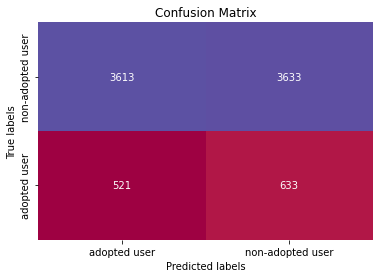

In [43]:
y_train_hat = model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_hat)*100

# Plot confusion matrix
ax = sns.heatmap(confusion_matrix(y_train, y_train_hat), annot=True, fmt='g', cbar=False, cmap="Spectral")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['adopted user', 'non-adopted user'])
ax.yaxis.set_ticklabels(['non-adopted user', 'adopted user'])

print('Training accuracy: %.2f %%' % train_accuracy)

## Testing Score

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Testing accuracy: 50.8333 %


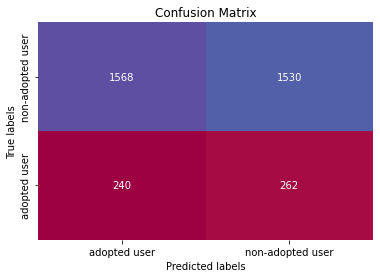

In [44]:
y_test_hat = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_hat)*100

# Plot confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_test_hat), annot=True, fmt='g', cbar=False, cmap="Spectral")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['adopted user', 'non-adopted user'])
ax.yaxis.set_ticklabels(['non-adopted user', 'adopted user'])

print('Testing accuracy: %.4f %%' % test_accuracy) 

In [45]:
print(classification_report(y_test, y_test_hat, digits=3))

              precision    recall  f1-score   support

         0.0      0.867     0.506     0.639      3098
         1.0      0.146     0.522     0.228       502

    accuracy                          0.508      3600
   macro avg      0.507     0.514     0.434      3600
weighted avg      0.767     0.508     0.582      3600



In [46]:
model_coef_df = pd.DataFrame(model.coef_, columns = X_train.columns).T
model_coef_df.columns = ['model_coef']
model_coef_df.sort_values(by=['model_coef'], ascending=False)

,model_coef
PERSONAL_PROJECTS,0.001057
opted_in_to_mailing_list,0.000732
last_session_creation_referral_id,0.000622
GUEST_INVITE,0.000547
enabled_for_marketing_drip,0.000521
creation_time_days,0.000437
is_big_org,0.000388
SIGNUP,0.000078
ORG_INVITE,-0.000309
creation_time_dow,-0.000335


Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period gives the following results. 
It is important to note that only 13.5% of all users are adopted users. 
The majority of users only logged in once (70.7%) and would not count as an adopted user. 

The factors which predict future user adoption are: (in ranked order)
- If the user was invited to join another user's personal workspace and created their account under 'PERSONAL_PROJECTS'
- If the user is opted into the mailing list
- How long the user's referral has opened their account
- If the user was invited as guest invite (invited to an organization as a guest with limited permissions)
- If the user is opted into the regular marketing email drip
- How long it has been since the user signed up for their account
- If the user is invited to an organization (as a full member) and is is one of the organizations with more than 50 members
- If the user signed up via the website
